# Main Result
Generates the figure and computes the evaluation metrics for the main result

## Initialisation

In [1]:
import itertools
import json
import numpy as np
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm

import initialise
import common
from analysis_utils import calc_statistics, plot_results
from display_utils import truncate_colormap

In [2]:
SCENARIOS = ['out-of-site', 'within-site']
samples_file = os.path.join(common.DATASETS_DIR, 'samples_365days.csv')
model_dir1 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[0]}_models')
model_dir2 = os.path.join(common.MODELS_DIR, f'{SCENARIOS[1]}_models')
holdout_file = os.path.join('data', 'holdout_index.csv')
design_file = os.path.join('data', 'design_index.csv')
output_dir = common.FIGURES_DIR

In [3]:
model = common.ANALYSIS_MODEL
ensemble_size = common.ENSEMBLE_SIZE
ensemble_runs = common.ENSEMBLE_RUNS
precision = 2

In [4]:
with open(os.path.join(model_dir2, 'model_params.json'), 'r') as f:
    ws_params = json.load(f)

## Get the samples and predictions

In [5]:
samples1 = pd.read_csv(samples_file, index_col=0)
predict1 = pd.read_csv(os.path.join(model_dir1, f'ensemble{ensemble_size}_{model}.csv'), index_col=0).reindex(samples1.index)

predict2 = pd.read_csv(os.path.join(model_dir2, f'ensemble{ensemble_size}_{model}.csv'), index_col=0)
samples2 = samples1.reindex(predict2.index)

holdout_samples = pd.read_csv(holdout_file, index_col=0)
design_samples = pd.read_csv(design_file, index_col=0)

In [6]:
stats1 = pd.read_csv(os.path.join(model_dir1, f'ensemble{ensemble_size}_stats.csv'), index_col=(0,1)).loc[model].T
means1 = stats1.mean()
stats2 =  pd.read_csv(os.path.join(model_dir2, f'ensemble{ensemble_size}_stats.csv'), index_col=(0,1)).loc[model].T
means2 = stats2.mean()

## Model Plots

Generate scatter plots of the estimated versus measured LFMC using the first ensemble only. The statistic in the figure are the means of all 50 ensembles.

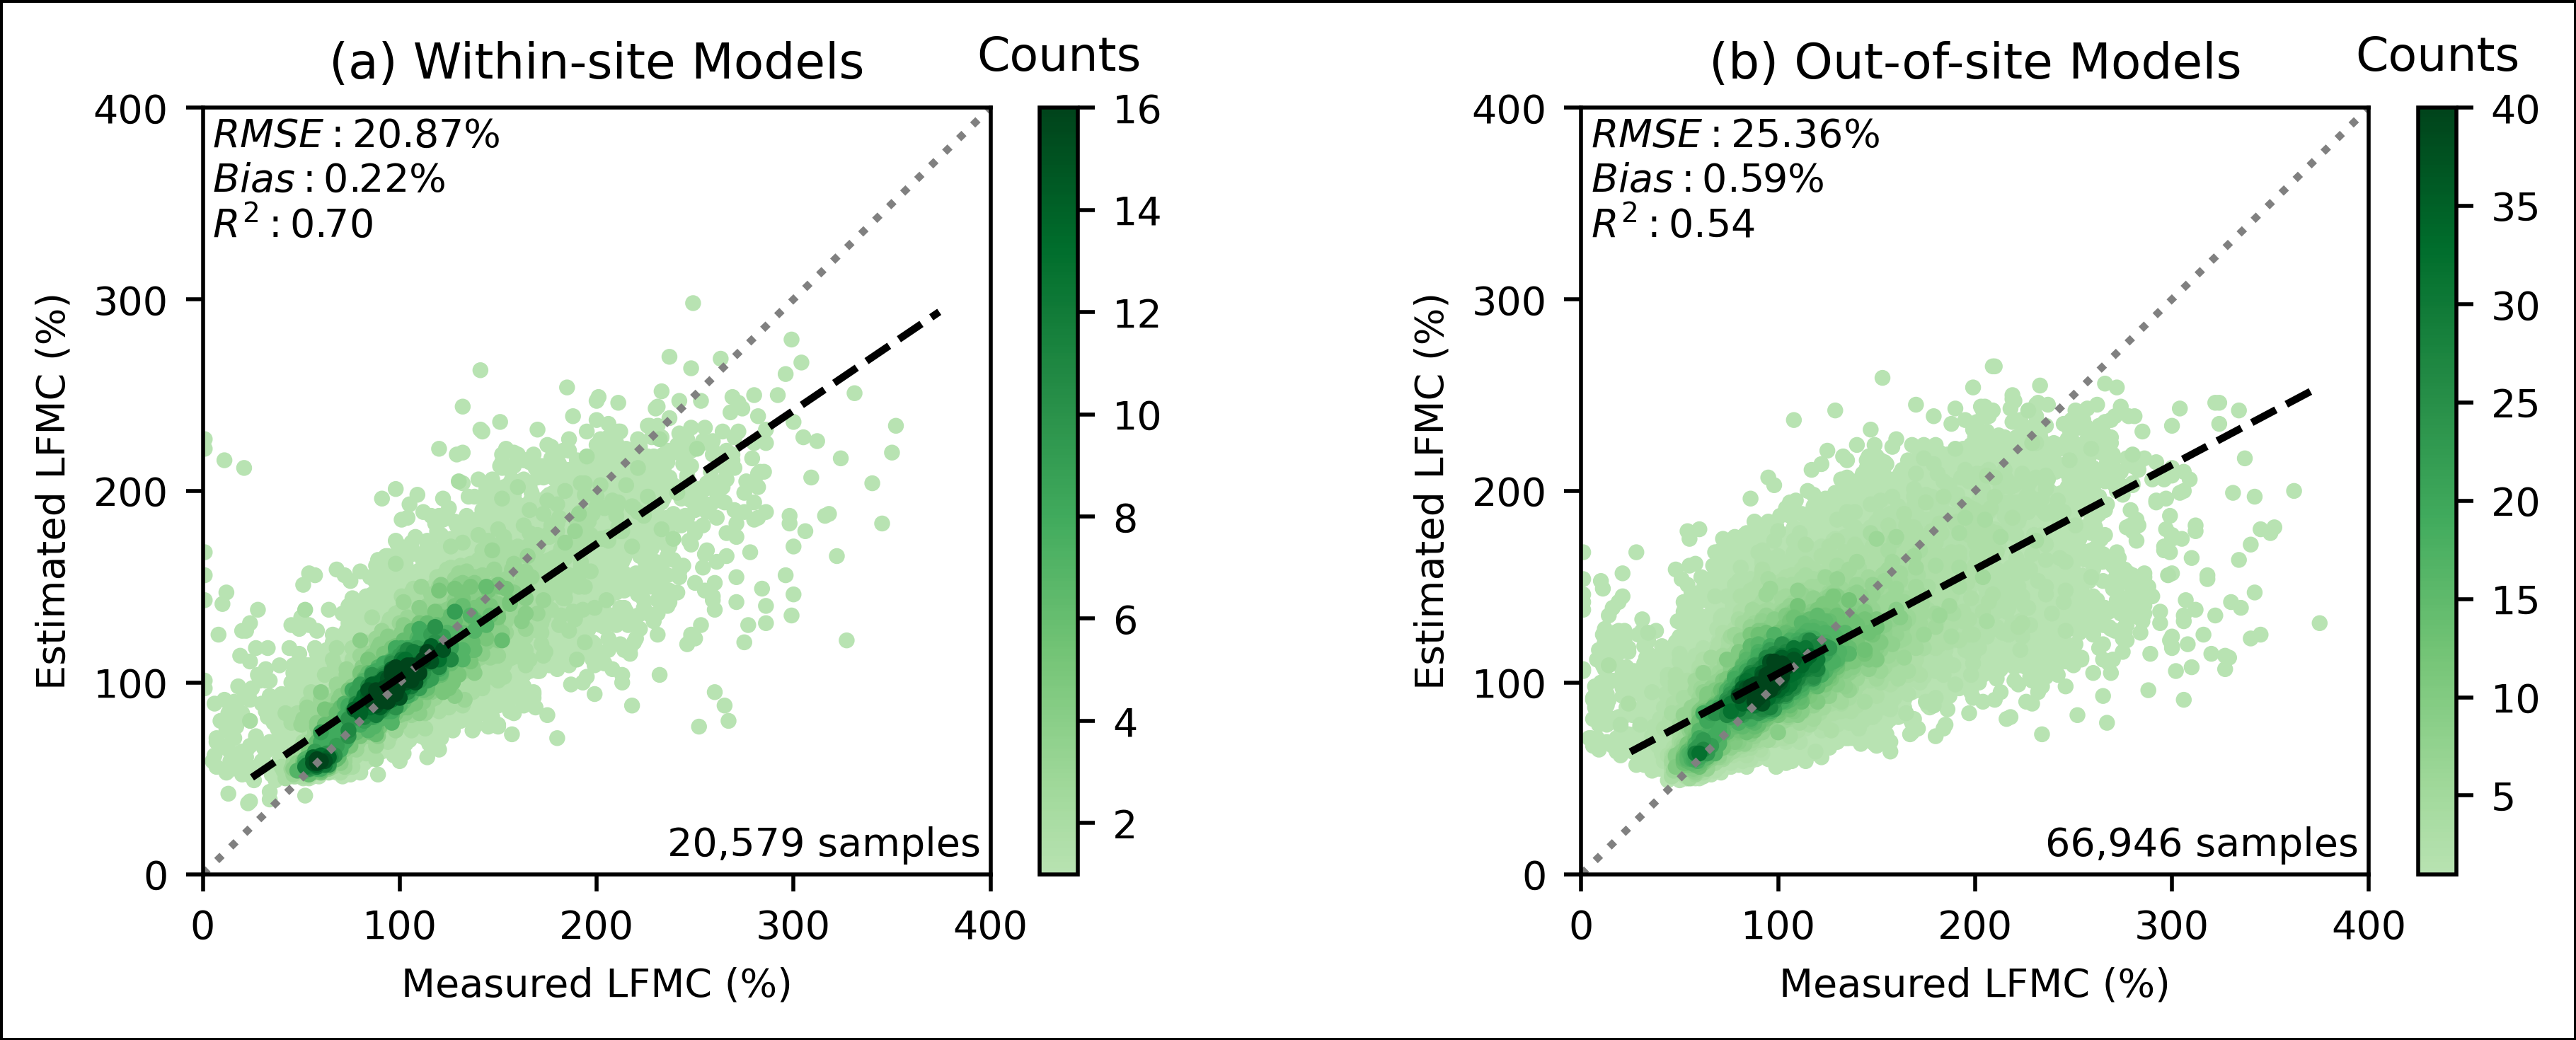

In [7]:
font_size = 8
vmax1 = 40
vmax2 = 16
vmin = 1
plt.rcParams.update({'font.size': font_size})
fig = plt.figure(constrained_layout=False, figsize=(8.617, 2.87), dpi=500, linewidth=1, edgecolor="black")
gspec = fig.add_gridspec(ncols=2, nrows=1)
cmap = truncate_colormap(plt.get_cmap('Greens'), minval=0.3, maxval=1.0, n=-1)

plot = fig.add_subplot(gspec[0, 0])
plot_results(f'(a) {SCENARIOS[1].capitalize()} Models', samples2['LFMC value'], predict2['0'],
             top_text=means2, bottom_text=f'{predict2.shape[0]:,} samples',
             lower=0, upper=400, diagonal=True, regress='black',
             ax=plot, cmap=cmap, vmin=vmin, vmax=vmax2)
plot.set_yticks(range(0, 500, 100))
cbar2 = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax2), cmap=cmap), ax=plot, aspect=20)
cbar2.ax.set_title('Counts', y=1.01)
cbar2.set_ticks(range(2, 18, 2))

plot = fig.add_subplot(gspec[0, 1])
plot_results(f'(b) {SCENARIOS[0].capitalize()} Models', samples1['LFMC value'], predict1['0'],
             top_text=means1, bottom_text=f'{predict1.shape[0]:,} samples',
             lower=0, upper=400, diagonal=True, regress='black',
             ax=plot, cmap=cmap, vmin=vmin, vmax=vmax1)
plot.set_yticks(range(0, 500, 100))
cbar1 = fig.colorbar(cm.ScalarMappable(norm=Normalize(vmin=vmin, vmax=vmax1), cmap=cmap), ax=plot, aspect=20)
cbar1.ax.set_title('Counts', y=1.01)
cbar1.set_ticks(range(5, 45, 5))

plt.subplots_adjust(wspace=0.4)
fig.savefig(os.path.join(output_dir, 'Main result.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.2, dpi=500)

## Main Result - Summary Statistics

### Within-Site Models
Calculate and display all metrics for the within-site models

In [8]:
design_samples2 = samples2.loc[design_samples.index.intersection(samples2.index)]
design_predict = predict2.loc[design_samples2.index]
design_stats = pd.DataFrame([calc_statistics(design_samples2['LFMC value'], pred_[1]) for pred_ in design_predict.iteritems()])

holdout_samples2 = samples2.loc[holdout_samples.index.intersection(samples2.index)]
holdout_predict = predict2.loc[holdout_samples2.index]
holdout_stats = pd.DataFrame([calc_statistics(holdout_samples2['LFMC value'], pred_[1]) for pred_ in holdout_predict.iteritems()])

years = [y for y in range(ws_params['splitYear'], ws_params['splitYear'] + ws_params['splitFolds'])]
stats = [stats2]
counts = [predict2.shape[0]]
for year in years:
    year_preds = predict2[samples2[ws_params['yearColumn']] == year]
    counts.append(year_preds.shape[0])
    stats_ = pd.DataFrame([calc_statistics(samples2['LFMC value'][year_preds.index], pred_[1]) for pred_ in year_preds.iteritems()])
    stats.append(stats_)

counts.extend([design_predict.shape[0], holdout_predict.shape[0]])
stats.extend([design_stats, holdout_stats])
means = [stats_.mean() for stats_ in stats]
stds = [stats_.std() for stats_ in stats]

group_names = ['All samples'] + years + ['Design samples', 'Held out samples']
means = pd.concat(means, keys=group_names).unstack()
stds = pd.concat(stds, keys=group_names).unstack()
counts = pd.Series(counts, index=group_names)
df_list = [counts, means.RMSE, stds.RMSE, means.Bias, stds.Bias, means.R2, stds.R2]
pd.concat(df_list, axis=1).set_axis(['Samples', 'RMSE-mean', 'RMSE-std', 'Bias-mean', 'Bias-std', 'R2-mean', 'R2-std'], axis=1).round(precision)

,Samples,RMSE-mean,RMSE-std,Bias-mean,Bias-std,R2-mean,R2-std
All samples,20579,20.87,0.03,0.22,0.13,0.70,0.0
2014,5555,20.07,0.07,1.64,0.22,0.68,0.0
2015,5200,22.33,0.08,-1.06,0.24,0.66,0.0
2016,4966,20.64,0.05,0.48,0.27,0.72,0.0
2017,4858,20.37,0.04,-0.30,0.25,0.71,0.0
Design samples,8172,21.40,0.04,-0.00,0.15,0.68,0.0
Held out samples,12407,20.51,0.03,0.37,0.13,0.71,0.0


### Out of Site Models
Calculate and display all metrics for the out-of-site models

In [9]:
design_samples1 = samples1.loc[design_samples.index.intersection(samples1.index)]
design_predict = predict1.loc[design_samples.index]
design_stats = pd.DataFrame([calc_statistics(design_samples1['LFMC value'], pred_[1]) for pred_ in design_predict.iteritems()])

holdout_samples1 = samples1.loc[holdout_samples.index.intersection(samples1.index)]
holdout_predict = predict1.loc[holdout_samples.index]
holdout_stats = pd.DataFrame([calc_statistics(holdout_samples1['LFMC value'], pred_[1]) for pred_ in holdout_predict.iteritems()])

group_names = ['All samples', 'Design samples', 'Held out samples']
means = pd.concat([means1, design_stats.mean(), holdout_stats.mean()], keys=group_names).unstack()
stds = pd.concat([stats1.std(), design_stats.std(), holdout_stats.std()], keys=group_names).unstack()
counts = pd.Series([predict1.shape[0], design_predict.shape[0], holdout_predict.shape[0]], index=group_names)
df_list = [counts, means.RMSE, stds.RMSE, means.Bias, stds.Bias, means.R2, stds.R2]
pd.concat(df_list, axis=1).set_axis(['Samples', 'RMSE-mean', 'RMSE-std', 'Bias-mean', 'Bias-std', 'R2-mean', 'R2-std'], axis=1).round(precision)

,Samples,RMSE-mean,RMSE-std,Bias-mean,Bias-std,R2-mean,R2-std
All samples,66946,25.36,0.02,0.59,0.15,0.54,0.01
Design samples,32210,25.43,0.03,1.02,0.17,0.54,0.00
Held out samples,34736,25.30,0.03,0.19,0.15,0.53,0.00
